<a href="https://colab.research.google.com/github/stupidbutsmart/DELE-CA1/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<style>
  b {
    color: red;
  }
</style>

## Section A CA1 CNN

Name: Jovan Heng Ghim Hong

Class: DAAA/2B/22

Admin No: 2401418

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [54]:
# Basic Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten ,Conv2D, MaxPooling2D , UpSampling2D, Cropping2D, ReLU, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.regularizers import l1 , l2
from tensorflow.keras.metrics import Precision , Recall
from sklearn.model_selection import RandomizedSearchCV,ParameterGrid, train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
warnings.filterwarnings('ignore')

### Creating UDFs to aid workflow

Before i start, i want to create some functions that can help me with my work.

basic functions like:
1. create model function
2. autoencoder function
3. data processing functions

etc.

This can help modularize my code (especially since im working with 2 models) and make it easier for future collaborater to understand

In [35]:
DATASET_PATH = './datasets/'
def get_greyscale_data(data_type , size):
  targets = [ target for target in os.listdir(DATASET_PATH + data_type)]

  rows = []
  for target in targets: 
    for file_name in os.listdir(os.path.join(DATASET_PATH , data_type ,  target)):
      # greyscale 
      img = image.load_img(os.path.join(DATASET_PATH , data_type, target , file_name ) ,color_mode='grayscale' , target_size=size)
      img = image.img_to_array(img) / 255.0 # divide by 255 to normalize it
      
      record = {'sequence' : img}
      for t in targets:
        record[t] = 1 if t == target else 0

      rows.append(record)

  return pd.DataFrame(rows , columns=['sequence'] + targets)



In [34]:
STORED_DATA = './stored_data/'
def build_raw_data(size):
  """ size should be a single number n for n x n pixels
  """
  res = []
  for file in os.listdir(STORED_DATA):
    if file.endswith('23.json') and (str (size) in file):
      res.append(pd.read_json(os.path.join(STORED_DATA , file)))
  return res

### Data Cleaning and Exploration

I plan to do manual inspection to clean my data, therfore cleaning will be done before importing

##### What i Found

1. There are some **duplicated images**, we will remove using **.drop_duplicates()** when we eventually import it

##### Test:

1. **Pumpkin** Folder Contains only **Tomatoes**
2. **Tomato** Folder Contains only **Pumpkins**
3. The folders are misnamed. For example **Bottle_Gourd and Cucumbers** should be **Cucumbers and Bottle Gourd**

So i just changed the names of those folders

##### Train:

1. **Beans** Contains some **Carrots**

I will move them into the **carrots** folder, incase of duplicates, they will be dropped later.

##### Validation:

Looks about as clean as it can get

In [11]:
## NOTE
## get_greyscale_data() takes awhile to run
## below there is a function that builds the DF from ./stored_data
## run if ./stored_data was not provided, otherwise run cell with build_data() below
train_data = get_greyscale_data('train' , (23 , 23))

KeyboardInterrupt: 

In [ ]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[0.7294118], [0.7294118], [0.7372549], [0.73...",1,0,0,0,0,0,0,0,0,0,0
1,"[[[0.7294118], [0.7294118], [0.7372549], [0.73...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[0.33333334], [0.49803922], [0.5019608], [0....",1,0,0,0,0,0,0,0,0,0,0
3,"[[[0.33333334], [0.49803922], [0.5019608], [0....",1,0,0,0,0,0,0,0,0,0,0
4,"[[[0.85882354], [0.8666667], [0.8784314], [0.8...",1,0,0,0,0,0,0,0,0,0,0


In [20]:
## repeat for test and validation
test_data = get_greyscale_data('test' , (23 , 23))
validation_data = get_greyscale_data('validation' , (23 , 23))


In [23]:
# Removing Duplicates
def remove_dupes(data):
  # Since we cannot hash lists, we need a string equivalent
  # This allows me to use the drop_duplicate function
  data['sequence_str'] = data['sequence'].apply(lambda x: str(x))
  data = data.drop_duplicates(subset=[col for col in data.columns if col != 'sequence'])
  data = data.drop(columns=['sequence_str'])
  return data


In [ ]:

test_data = remove_dupes(test_data)
train_data = remove_dupes(train_data)
validation_data = remove_dupes(validation_data)

In [13]:
train_data.head()

,sequence,Bean,Bitter_Gourd,Brinjal,Cabbage,Capsicum,Cauliflower and Broccoli,Cucumber and Bottle_Gourd,Potato,Pumpkin,Radish and Carrot,Tomato
0,"[[[0.7294117808], [0.7294117808], [0.737254917...",1,0,0,0,0,0,0,0,0,0,0
2,"[[[0.33333334330000003], [0.49803921580000005]...",1,0,0,0,0,0,0,0,0,0,0
4,"[[[0.8588235378], [0.8666666746], [0.878431379...",1,0,0,0,0,0,0,0,0,0,0
6,"[[[0.6980392337], [0.7058823705], [0.709803938...",1,0,0,0,0,0,0,0,0,0,0
8,"[[[0.6784313917], [0.6745098233], [0.674509823...",1,0,0,0,0,0,0,0,0,0,0


In order to save computional time, we will save the data, allowing us to build our df from it.

We are using json format, as integrates seamlessly with my **sequence** column

In [14]:
train_data.to_json(os.path.join(STORED_DATA , 'train_23.json') , orient='records')
test_data.to_json(os.path.join(STORED_DATA , 'test_23.json') , orient='records')
validation_data.to_json(os.path.join(STORED_DATA , 'validation_23.json') , orient='records')

With our data exported, we can reimport it 

In [6]:
test_data , train_data , validation_data = build_raw_data(23)

We can recontruct it and plot it using matplotlib 

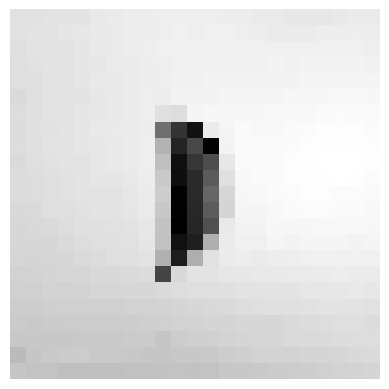

In [7]:
plt.imshow(train_data['sequence'].iloc[0] , cmap='gray')
plt.axis('off')
plt.show()

##### Comparing it to its real img counterpart
<style>
.two_col_row {
  display: grid;
  grid-template-columns: 1fr 1fr; /* Two equal columns */
  gap: 20px; /* Space between items */
  padding: 20px
}

img {
  height: auto;
  width: 100%;
}



  </style>
<div class='two_col_row'>
  <img src='./markdown/bean_1_imap.png'>
  <img src='./markdown/bean_1_original.jpg'>
</div>


looks like a very nice bean

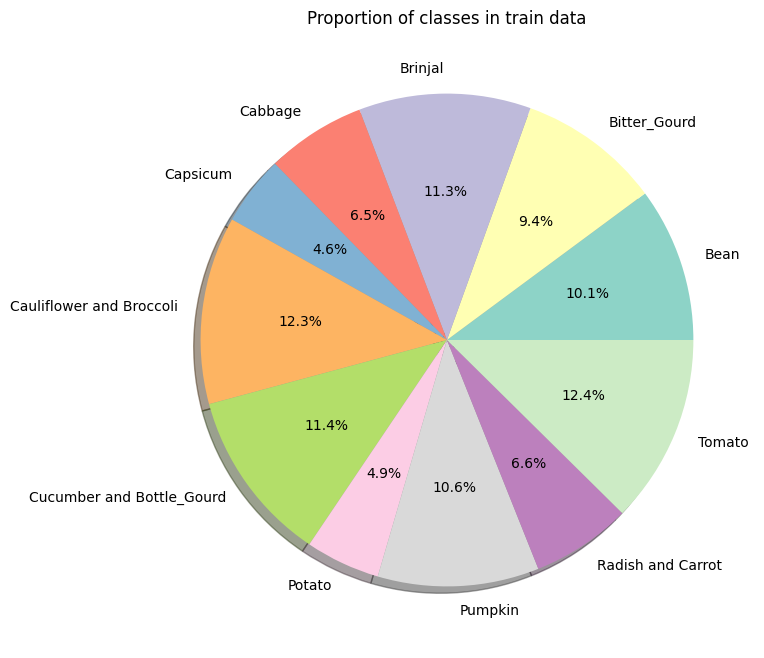

In [51]:
# Comparing classes

counts = []
for col in train_data.columns[1:]:
  amount_of_class = train_data[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=train_data.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in train data')
plt.show()

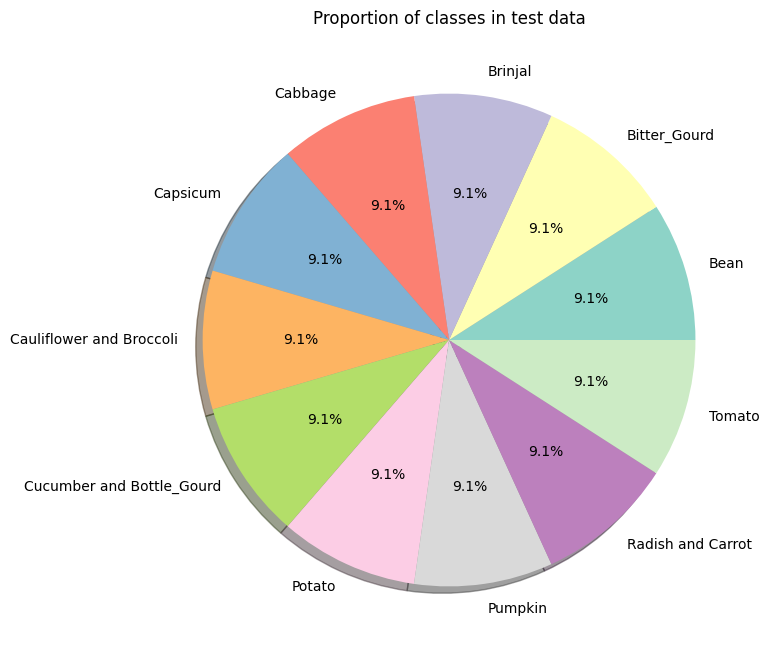

In [52]:
counts = []
for col in test_data.columns[1:]:
  amount_of_class = test_data[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=test_data.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in test data')
plt.show()

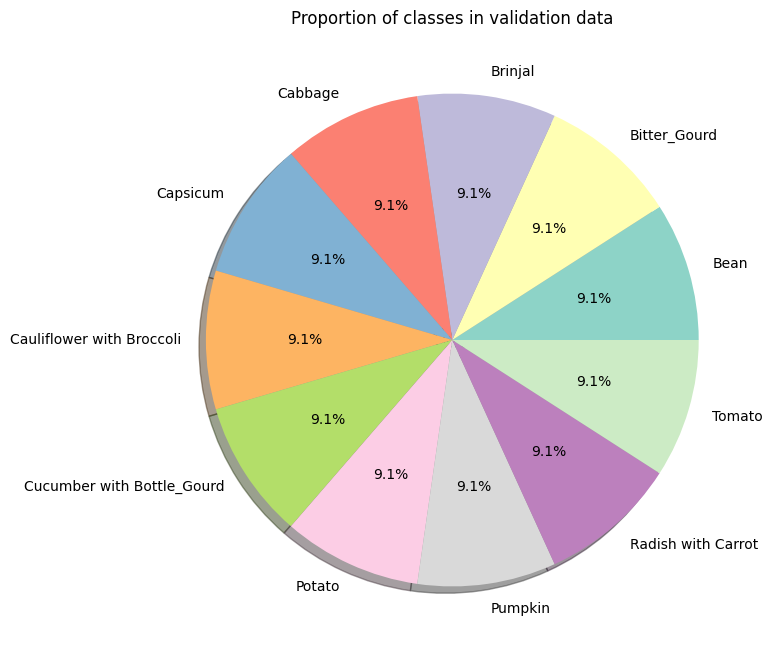

In [53]:
counts = []
for col in validation_data.columns[1:]:
  amount_of_class = validation_data[col].value_counts()[1]
  counts.append(amount_of_class)

plt.figure(figsize=(8 , 8))
plt.pie(counts, labels=validation_data.columns[1:], autopct='%1.1f%%', shadow=True, colors=plt.cm.Set3.colors[:11])
plt.title('Proportion of classes in validation data')
plt.show()

This shows that the train data has **unbalanced features** while the test and validation is **perfectly balanced**


This suggests that i should 

##### Creating Model

The Idea behind my model is going to be as follows:

1. Input Layer
2. Conv2d * **n** amounts
3. BatchNormalize
4. Activation Relu
5. Maxpooling/bottleneck layer
6. Flatten
7. Dense - softmax (we are doing multiclass-classification)

where layers 2-5 can be repeated **m** times.

For the grid Search, since i already have dedicated validation data, i will not be using kfold-cv.

In [ ]:
def create_model(n , m, max_neurons , 
            dropout, kernel_size, strides, padding, activation,
            has_encoder, kernel_regularization, activity_regularization,
            pooling_size, autoencoder
                 ):
  model = Sequential()

  # we want the neurons to be increasing, getting more complex further in
  neurons_arr = [32] # starting
  for _ in range(m -1 ):
    neurons_arr.append(min(neurons_arr[len(neurons_arr) - 1] * 2 ,  max_neurons))
  
  # add encoder if exists
  if has_encoder != None:
    model.add(autoencoder)

  for i in range(m):
    # Adding n number of conv2d
    for _ in range(n):
      model.add(Conv2D(neurons_arr[i], kernel_size, strides=strides, padding=padding, kernel_regularizer=l2(kernel_regularization), activity_regularizer=l1(activity_regularization)))

    model.add(BatchNormalization())
    model.add(eval(f'{activation}()'))
    model.add(MaxPooling2D((pooling_size) , padding='same'))

  
  model.add(Dropout(dropout))
  model.add(Flatten())
  model.add(Dense(128 , activation='relu'))
  model.add(Dense(11 , activation='softmax'))
  model.compile(loss='categorical_crossentropy' , optimizer='adam' , metrics=['accuracy'])
  return model
 
  


In [9]:
X_train = np.asarray(np.stack(train_data['sequence']) , dtype=np.float32)
y_train = np.asarray(train_data.drop(columns=['sequence']).values.astype(float), dtype=np.float32)

X_test = np.stack(test_data['sequence'])
y_test = test_data.drop(columns=['sequence']).values

X_validation = np.asarray(np.stack(validation_data['sequence']), dtype=np.float32)
y_validation = np.asarray(validation_data.drop(columns=['sequence']).values.astype(float) , dtype = np.float32)

In [10]:
# We are creating this autoencoder to compare against max 2d pooling
def generate_autoencoder():
  autoencoder = Sequential([
    # encoding part
    Conv2D(filters=128 , kernel_size=(3 , 3) , activation='relu' , input_shape=(23 , 23 , 1), padding='same'),
    MaxPooling2D((2 , 2), padding='same'),
    Conv2D(filters=32 , kernel_size=(3 , 3) , activation='relu', padding='same'), # bottleneck / compressed layer (32 features)
    MaxPooling2D((2 , 2), padding='same'),
    Conv2D(filters=16, kernel_size=(3 , 3) , activation='relu', padding='same'),
    # decoding part
    Conv2D(filters=32 , kernel_size=(3 , 3) , activation='relu', padding='same'),
    UpSampling2D((2 , 2)),
    Conv2D(filters=128, kernel_size=(3 , 3) , activation='relu', padding='same'),
    UpSampling2D((2 , 2)),
    Cropping2D(cropping=((0,1) , (0,1))), # ensures output is 23x23
    Conv2D(filters=1 , kernel_size=(3 , 3) , activation='sigmoid', padding='same') # output layer
  ])
  return autoencoder


In [12]:
# compile and fit
autoencoder = generate_autoencoder()
autoencoder.compile(loss='binary_crossentropy' , optimizer='adam')
autoencoder.fit(X_train , X_train, epochs=50, verbose=0, batch_size=64, validation_data=(X_validation , X_validation))

In [13]:
# we can export the autoencoder for better reproducability
autoencoder.save_weights(os.path.join('stored_models' , 'autoencoder_23.h5'))

In [11]:
# in the future , we can just load the weights
autoencoder = generate_autoencoder()
autoencoder.compile(loss='binary_crossentropy' , optimizer='adam')
autoencoder.load_weights(os.path.join('stored_models' , 'autoencoder_23.h5'))

In [11]:
hyper_params = { 
  'n': np.arange(1 , 5),
  'm': np.arange(1 , 5),
  'max_neurons':  [32 , 64 , 128 , 256],
  'dropout': np.arange(0.3 , 0.8 , 0.1),# 5
  'strides': [(1 , 1)],
  'padding': ['same'],
  'activation': ['ReLU' , 'LeakyReLU'],
  'has_encoder': [None, True], # true means to use autoencoder
  'kernel_size': [(3 , 3), (5 , 5)],
  'kernel_regularization': [0 , 1e-5 , 1e-6],
  'activity_regularization': [0 , 1e-6 , 1e-7],
  'pooling_size': [(2 ,2 ) , (3 ,3)]
}
batch_sizes = [16 , 32 , 64 , 128] 
val_losses = []
val_accuracies = []
fit_results = []
successful_params = []


In [12]:
random_samples = random.sample(list(ParameterGrid(hyper_params)),170)
# Random Search
for params in random_samples:
  for batch_size in batch_sizes:
    try:
      K.clear_session() # save gpu memory
      print(f'Tuning for {params}... \nbatch size {batch_size}')

      # Create and fit
      model = create_model(**params, autoencoder=Sequential(autoencoder.layers[:4]))
      early_stop = EarlyStopping(monitor='val_loss' , patience=5 , restore_best_weights=True)
      fit_result = model.fit(X_train, y_train, epochs=100 , 
                batch_size=batch_size, 
                validation_data=(X_validation , y_validation) 
                , callbacks=[early_stop]
                ,verbose = 0
                )

      # Eval and store 
      # will not be using cross val score since we have dedicated vaildation data.
      val_loss , val_accuracy = model.evaluate(X_validation , y_validation)
      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)
      fit_results.append(fit_result.history)
      successful_params.append(dict(params , **{'batch_size': batch_size})) # this is required since im skipping bad params

      print(f'Val loss: {val_loss} , val_accuracy: {val_accuracy}')
    except Exception as error:
      # handles any bad params configurations
      print('Error occured with this param configuration')
      print(error)
      continue
K.clear_session()

Tuning for {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.7000000000000002, 'has_encoder': True, 'kernel_regularization': 0, 'kernel_size': (3, 3), 'm': 2, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1)}... 
batch size 16
69/69 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.7827
Val loss: 0.6907171607017517 , val_accuracy: 0.7827273011207581
Tuning for {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.7000000000000002, 'has_encoder': True, 'kernel_regularization': 0, 'kernel_size': (3, 3), 'm': 2, 'max_neurons': 32, 'n': 3, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1)}... 
batch size 32
69/69 [==============================] - 0s 4ms/step - loss: 0.5417 - accuracy: 0.8350
Val loss: 0.5417444705963135 , val_accuracy: 0.8349999785423279
Tuning for {'activation': 'ReLU', 'activity_regularization': 1e-06, 'dropout': 0.7000000000000002, 'has_encoder': True, 'kerne

In [13]:
# Exporting 
results = pd.DataFrame({
  'params': successful_params,
  'validation_accuracies': val_accuracies,
  'validation_losses': val_losses,
  'fit_results': fit_results
})

In [14]:

# attempt to pickle, if error just use .json format
# json works since weights for autoencoder stored seperately
# we just need the architecture (what params are used)
with open(os.path.join('tuning_results' , '23_tuning_results_v3.pkl') , 'wb') as f:
  pickle.dump(results, f)

In [15]:
# Importing the results
results = None

with open(os.path.join('tuning_results' , '23_tuning_results_v3.pkl') , 'rb') as f:
  results = pickle.load(f)


In [16]:

# Deconstructing Results

val_accuracies = results['validation_accuracies']
val_losses = results['validation_losses']
successful_params = results['params']
fit_results = results['fit_results']
                   

##### Best Model Analysis

In [17]:
# Getting best the set of parameters
best_index = np.argmin(val_losses)
best_params = successful_params[best_index]
best_acc = val_accuracies[best_index]
best_loss = val_losses[best_index]
                                 
print(f'Best Params: {best_params}')
print(f'Best acc: {best_acc}')
print(f'Best loss: {best_loss}')

Best Params: {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.4, 'has_encoder': None, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 3, 'max_neurons': 64, 'n': 2, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 16}
Best acc: 0.8668181896209717
Best loss: 0.4342515170574188


Here i want to consider the top 5, since i plan to tune the amount of data feeded into the NN

There is chance that 'worse performing' models may perform better with specific amounts of data


For now i want to look at the loss and learning rates

In [24]:
top_5_indexes = np.argsort(val_losses)[:5]



In [ ]:

for i in top_5_indexes:
  validation_loss = fit_results[i]['val_loss']
  validation_accuracy = fit_results[i]['val_accuracy']
  print(val_losses[i])
  print(val_accuracies[i])

  train_loss = fit_results[i]['loss']
  train_accuracy = fit_results[i]['accuracy']

  epochs = range(1 , len(validation_accuracy) + 1)

  fig , ax = plt.subplots(1 , 2 , figsize=(16 , 6 ,))

  print(successful_params[i])

  # loss
  ax[0].plot(epochs , validation_loss, label='validation')
  ax[0].plot(epochs , train_loss, label='train')
  ax[0].legend()
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')
  ax[0].set_title('loss against epochs')

  # acc
  ax[1].plot(epochs , validation_accuracy, label='validation')
  ax[1].plot(epochs , train_accuracy, label='train')
  ax[1].legend()
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('accuracy against epochs')
  plt.show()


In [18]:
param_data_permu = []
param_data_permu_history = []
param_data_permu_loss = []
param_data_permu_accuracy = []

In [40]:
# Hyper tuning amount of data fed into the model
for i in top_5_indexes:
  params = successful_params[i]
  
  splits = [0.25 , 0.5 , 0.75 , 1] 
  for split in splits:
    model_params = {k:v for k , v in params.items() if k != 'batch_size'}
    print(f'Traing {params}\n on {split} of data')
    if split != 1:
      X_train_split , _ ,y_train_split , _ = train_test_split(X_train , y_train, random_state=42 , train_size=split , stratify=y_train)
      X_train_split = np.asarray(X_train_split, dtype=np.float32)
      y_train_split = np.asarray(y_train_split, dtype=np.float32)
    else:
      X_train_split = np.asarray(X_train, dtype=np.float32)
      y_train_split = np.asarray(y_train, dtype=np.float32)

    X_validation = np.asarray(X_validation, dtype=np.float32)
    y_validation = np.asarray(y_validation, dtype=np.float32)


    # with different amounts of data epochs required might be different
    early_stop = EarlyStopping(monitor='val_loss' , patience=10 , restore_best_weights=True)
    model = create_model(**model_params , autoencoder=Sequential(autoencoder.layers[:4]))
    history = model.fit(
      X_train_split , y_train_split , 
      epochs=200, batch_size=params['batch_size'], 
      validation_data=(X_validation , y_validation),
      verbose = 0,
      callbacks=[early_stop]
      )

    # Eval and store
    val_loss , val_accuracy = model.evaluate(X_validation , y_validation)
    print(f'Validation Loss: {val_loss}')
    print(f'Validation accuracy: {val_accuracy}')

    param_data_permu.append({
      **params, 
      'size': split
    })
    param_data_permu_history.append(history.history)
    param_data_permu_accuracy.append(val_accuracy)
    param_data_permu_loss.append(val_loss)

  # Plotting graph
  last_4_val_loss = param_data_permu_loss[-4:]
  plt.plot(splits , last_4_val_loss)
  plt.title('Validation loss against data splits')
  plt.xlabel('splits')
  plt.ylabel('val loss')
  plt.show()


Traing {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.4, 'has_encoder': None, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 3, 'max_neurons': 64, 'n': 2, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 16}
 on 0.25 of data


KeyboardInterrupt: 

The graphs generally show that using more data helps to improve the validation loss

In [45]:
data_tune_results = pd.DataFrame({
 'permatation': param_data_permu,
 'history': param_data_permu_history,
 'validation_loss': param_data_permu_loss,
 'validation_accuracy': param_data_permu_accuracy
})

with open(os.path.join('tuning_results' , '23_data_tuning_v2.pkl') , 'wb') as f:
  pickle.dump(data_tune_results , f)

In [19]:
# Importing the results
results = None

with open(os.path.join('tuning_results' , '23_data_tuning_v2.pkl') , 'rb') as f:
  results = pickle.load(f)


In [21]:
param_data_permu = results['permatation']
param_data_permu_history = results['history']
param_data_permu_loss = results['validation_loss']
param_data_permu_accuracy = results['validation_accuracy']

In [22]:
# Here we can decide on what is the best set of params and partition of data
best_index = np.argmin(param_data_permu_loss)
size = param_data_permu[best_index]['size']
print(f'Best params: {param_data_permu[best_index]}')
print(f'Best size: {size}')
print(f'Val Loss: {param_data_permu_loss[best_index]}')
print(f'Val accuracy: {param_data_permu_accuracy[best_index]}')

Best params: {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.4, 'has_encoder': None, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 3, 'max_neurons': 64, 'n': 2, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 16, 'size': 1}
Best size: 1
Val Loss: 0.44640398025512695
Val accuracy: 0.8827272653579712


##### Making Predictions

The results suggests that using all the training data is optimal for this problem

I want to try the top 2 models and compare them against each other

##### Choice of Epochs

I will use early stop with patience 3. 

With **restore_best_weights**, it should be able to capture the point **right before overfitting**

Though if i feel like it is unable to i will analyse the graph further and manually set the epoch

In [26]:
params_to_consider = [successful_params[i] for i in top_5_indexes]

Testing {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.4, 'has_encoder': None, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 3, 'max_neurons': 64, 'n': 2, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 16}
69/69 [==============================] - 1s 8ms/step


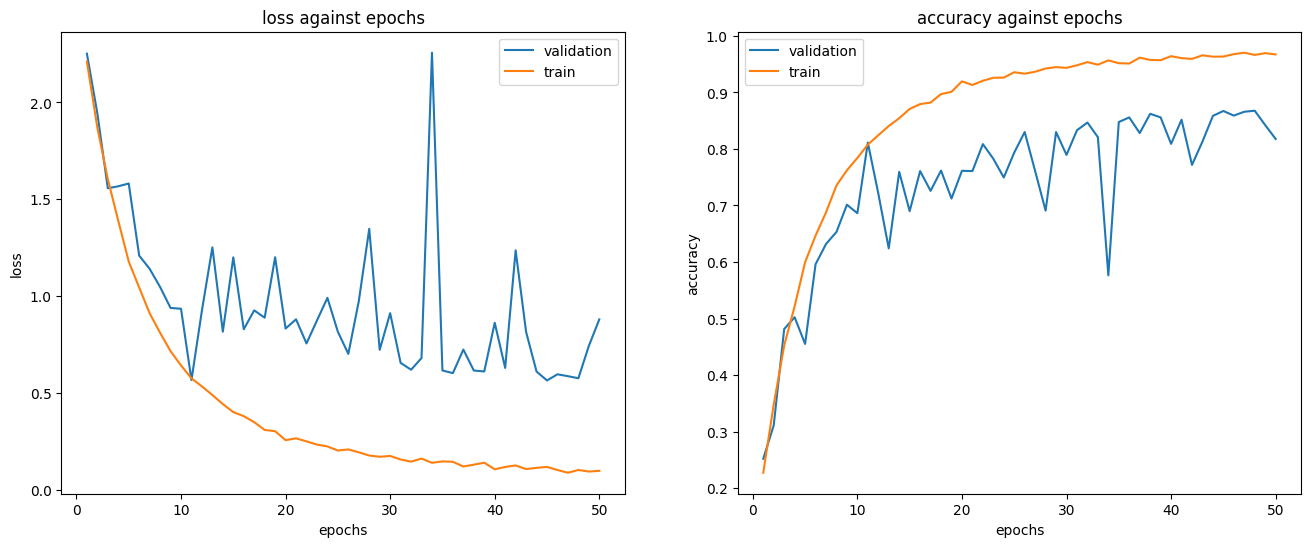

              precision    recall  f1-score   support

           0       0.60      0.97      0.74       200
           1       0.84      0.81      0.83       200
           2       0.92      0.82      0.87       200
           3       0.93      0.57      0.71       200
           4       0.98      0.86      0.91       200
           5       0.61      0.61      0.61       200
           6       0.78      0.94      0.85       200
           7       0.95      0.80      0.87       200
           8       0.99      0.79      0.88       200
           9       0.78      0.93      0.85       200
          10       0.79      0.78      0.78       200

    accuracy                           0.81      2200
   macro avg       0.83      0.81      0.81      2200
weighted avg       0.83      0.81      0.81      2200



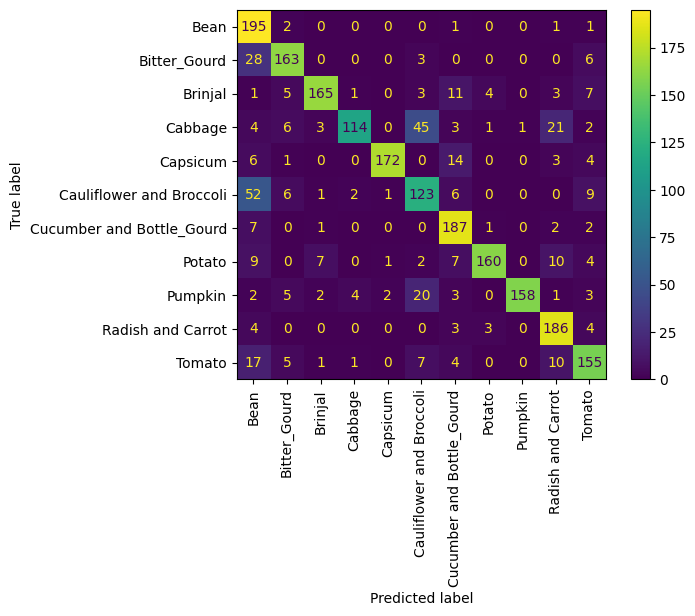

Testing {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.3, 'has_encoder': None, 'kernel_regularization': 1e-06, 'kernel_size': (5, 5), 'm': 4, 'max_neurons': 128, 'n': 1, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1), 'batch_size': 64}
69/69 [==============================] - 0s 4ms/step


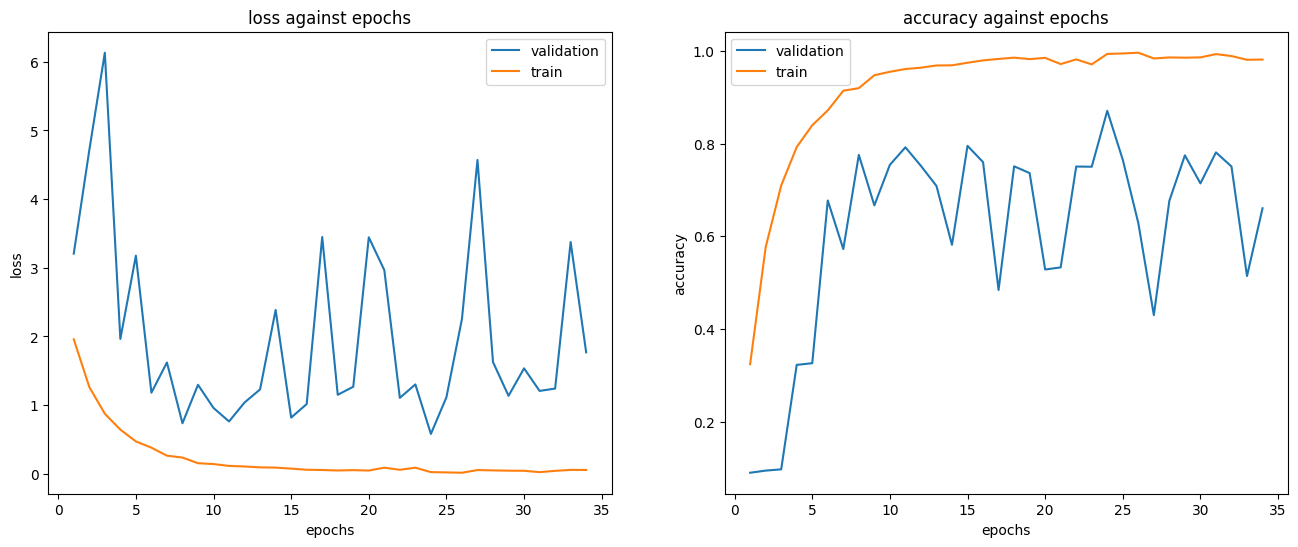

              precision    recall  f1-score   support

           0       0.97      0.41      0.58       200
           1       1.00      0.13      0.23       200
           2       0.69      0.78      0.73       200
           3       0.94      0.23      0.37       200
           4       0.91      0.83      0.87       200
           5       0.82      0.47      0.60       200
           6       0.80      0.72      0.76       200
           7       0.85      0.73      0.78       200
           8       0.94      0.69      0.79       200
           9       0.37      0.99      0.54       200
          10       0.36      0.86      0.51       200

    accuracy                           0.62      2200
   macro avg       0.78      0.62      0.61      2200
weighted avg       0.78      0.62      0.61      2200



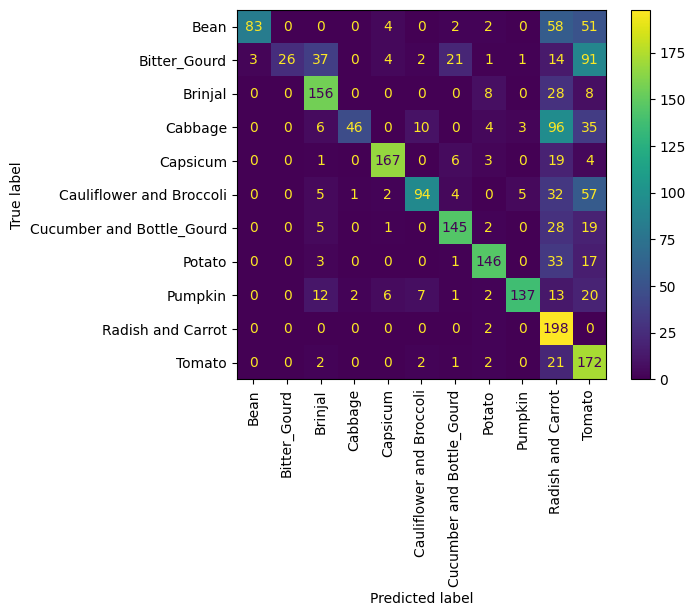

Testing {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.3, 'has_encoder': None, 'kernel_regularization': 1e-06, 'kernel_size': (5, 5), 'm': 4, 'max_neurons': 128, 'n': 1, 'padding': 'same', 'pooling_size': (2, 2), 'strides': (1, 1), 'batch_size': 16}
69/69 [==============================] - 0s 2ms/step


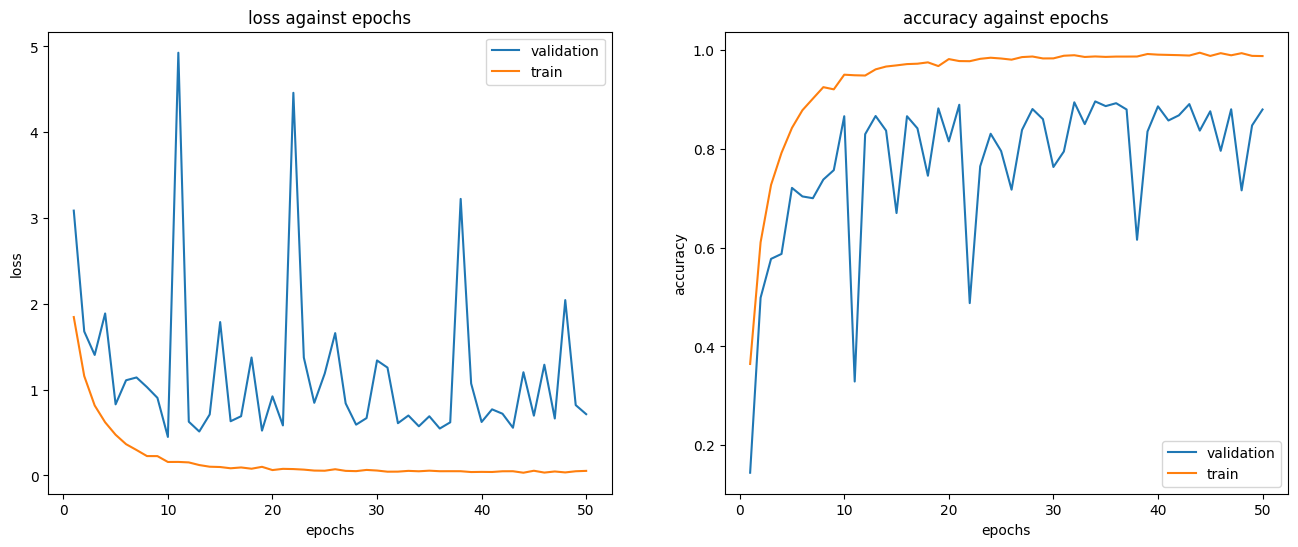

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       200
           1       0.90      0.96      0.93       200
           2       0.89      0.98      0.94       200
           3       0.98      0.59      0.74       200
           4       0.98      0.94      0.96       200
           5       0.64      0.88      0.74       200
           6       0.95      0.93      0.94       200
           7       0.92      0.94      0.93       200
           8       0.87      0.90      0.88       200
           9       0.98      0.86      0.91       200
          10       0.89      0.83      0.86       200

    accuracy                           0.89      2200
   macro avg       0.90      0.88      0.88      2200
weighted avg       0.90      0.89      0.88      2200



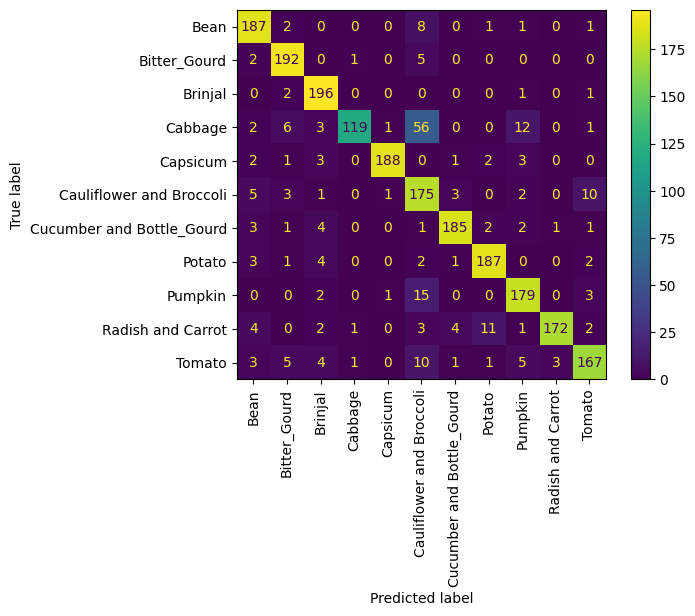

Testing {'activation': 'ReLU', 'activity_regularization': 0, 'dropout': 0.4, 'has_encoder': None, 'kernel_regularization': 0, 'kernel_size': (5, 5), 'm': 3, 'max_neurons': 64, 'n': 2, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 64}
69/69 [==============================] - 0s 3ms/step


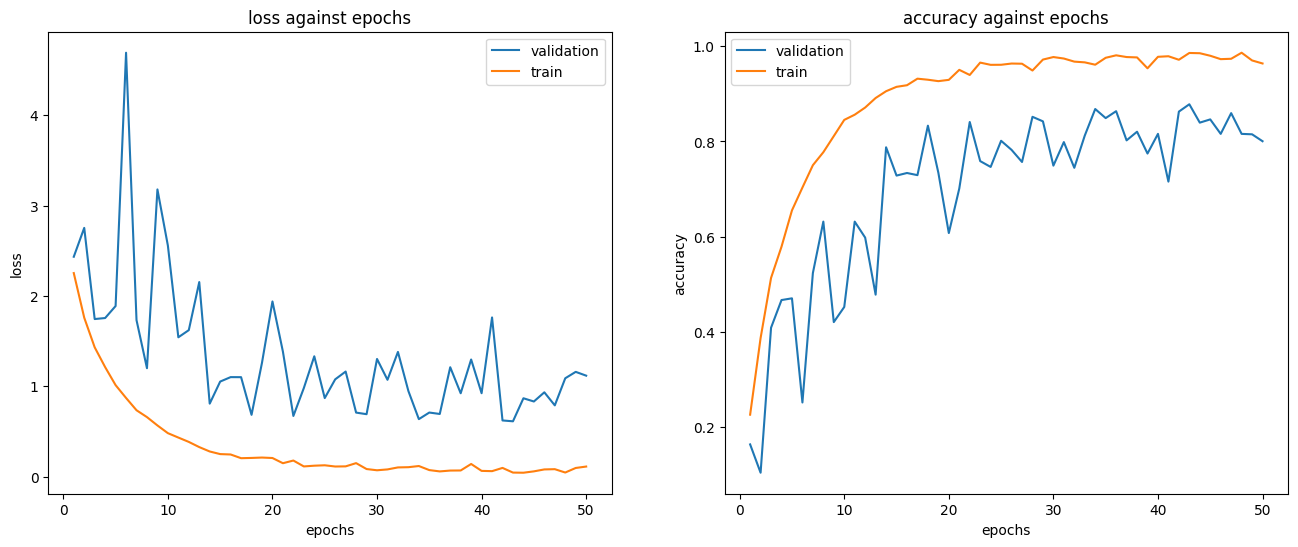

              precision    recall  f1-score   support

           0       0.64      0.97      0.77       200
           1       0.81      0.88      0.85       200
           2       0.98      0.78      0.87       200
           3       0.93      0.41      0.56       200
           4       0.87      0.89      0.88       200
           5       0.51      0.81      0.63       200
           6       0.93      0.76      0.84       200
           7       0.92      0.85      0.88       200
           8       0.71      0.85      0.77       200
           9       0.97      0.77      0.86       200
          10       0.86      0.70      0.77       200

    accuracy                           0.79      2200
   macro avg       0.83      0.79      0.79      2200
weighted avg       0.83      0.79      0.79      2200



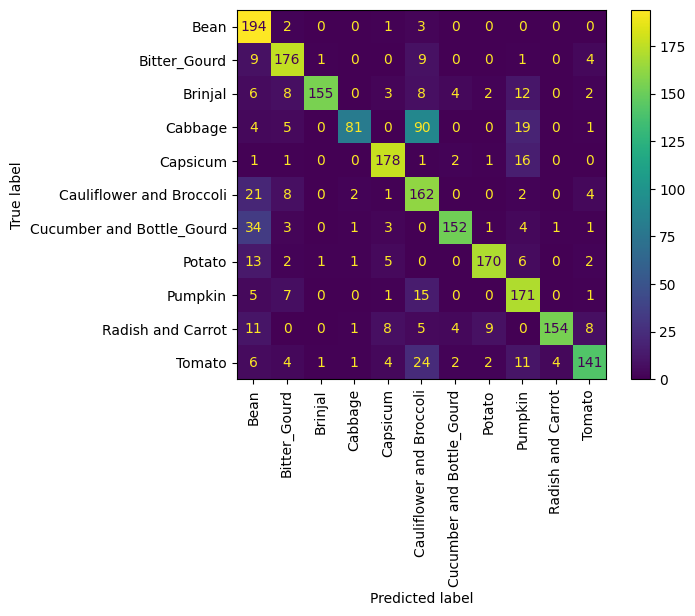

Testing {'activation': 'ReLU', 'activity_regularization': 1e-07, 'dropout': 0.3, 'has_encoder': None, 'kernel_regularization': 1e-06, 'kernel_size': (5, 5), 'm': 2, 'max_neurons': 64, 'n': 2, 'padding': 'same', 'pooling_size': (3, 3), 'strides': (1, 1), 'batch_size': 16}
69/69 [==============================] - 0s 3ms/step


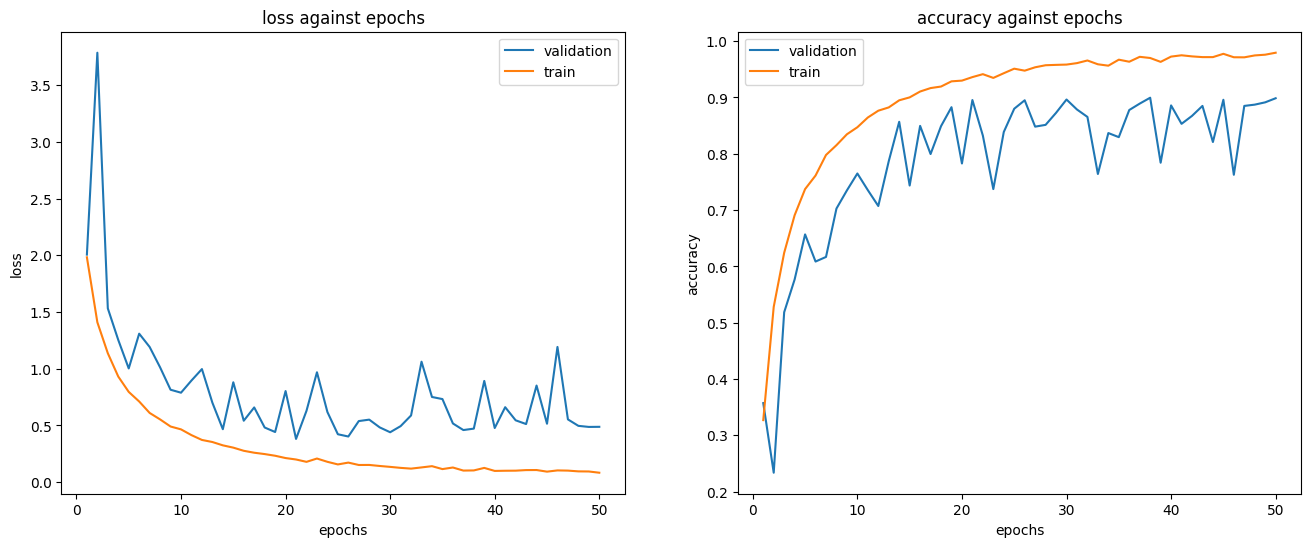

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       200
           1       0.99      0.83      0.91       200
           2       0.89      0.93      0.91       200
           3       0.96      0.81      0.88       200
           4       0.95      0.93      0.94       200
           5       0.72      0.91      0.80       200
           6       0.87      0.97      0.92       200
           7       0.94      0.94      0.94       200
           8       0.90      0.94      0.92       200
           9       0.93      0.94      0.94       200
          10       0.91      0.82      0.86       200

    accuracy                           0.90      2200
   macro avg       0.91      0.90      0.90      2200
weighted avg       0.91      0.90      0.90      2200



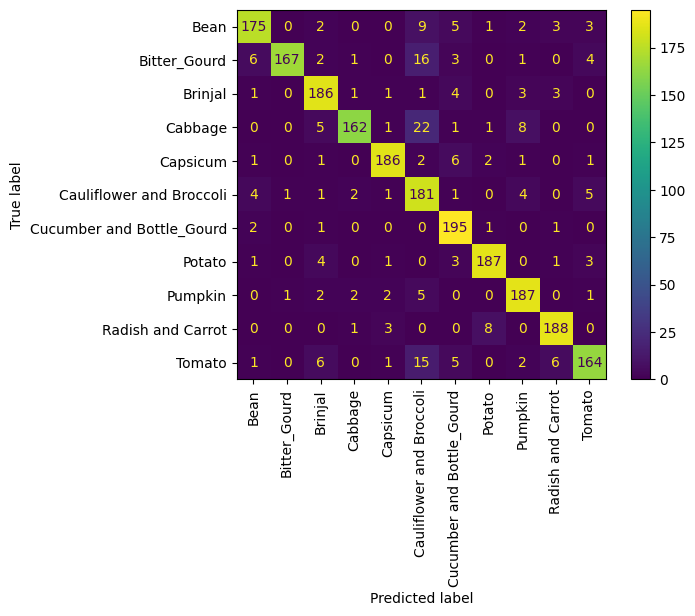

In [36]:
for i , params in enumerate(params_to_consider):
  print(f'Testing {params}')
  model_params = {k:v for k , v in params.items() if k != 'batch_size'}
  # callbacks
  early_stopper = EarlyStopping(patience=8 , monitor='loss', restore_best_weights=True)
  model_checkpoint = ModelCheckpoint(filepath=os.path.join('stored_models' , f'best_weights_params_set{i}_size_23.h5'),
                                      monitor='loss',
                                      save_best_only=True,
                                      save_weight_only=True,                                    
                                      mode='min'
                                     )
  # fitting
  model = create_model(**model_params , autoencoder=Sequential(autoencoder.layers[:4]))
  results = model.fit(X_train , y_train,
                      epochs=50,
                      batch_size=params['batch_size'],
                      callbacks=[early_stopper , model_checkpoint],
                      validation_data = (X_validation , y_validation),
                      verbose=0
                      )
  epochs = len(results.history['loss'])
  # predict
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1) # in non-onehot encoded format

  # Plots
  validation_loss = results.history['val_loss']
  validation_accuracy = results.history['val_accuracy']
  
  train_loss = results.history['loss']
  train_accuracy = results.history['accuracy']
  
  epochs = range(1 , len(train_loss) + 1)

  fig , ax = plt.subplots(1 ,2 , figsize=(16 , 6))

  # loss
  ax[0].plot(epochs , validation_loss, label='validation')
  ax[0].plot(epochs , train_loss, label='train')
  ax[0].legend()
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('loss')
  ax[0].set_title('loss against epochs')

  # acc
  ax[1].plot(epochs , validation_accuracy, label='validation')
  ax[1].plot(epochs , train_accuracy, label='train')
  ax[1].legend()
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('accuracy')
  ax[1].set_title('accuracy against epochs')
  plt.show()

  ## results
  y_test_labels = np.argmax(y_test , axis=1)
  print(classification_report(y_test_labels , y_pred))
  cm = confusion_matrix(y_test_labels , y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.columns[1:])
  disp.plot()
  plt.xticks(rotation=90)
  plt.show()

### 101 x 101

Now i can do the exact same steps for 101x101 size

3